In [1]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
from sklearn import metrics, utils
from joblib import Parallel, delayed
from tqdm import tqdm#_notebook as tqdm
import scipy
import scipy.special
import itertools
import yaml

with open('config.yaml') as f:
    config = yaml.load(f)
    data_path = config['data_path']

/home/tangsp/venv/lib/python3.6/site-packages/ipykernel_launcher.py:14: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [2]:
matplotlib.rcParams['font.size'] = 12.0
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = [
    'Roboto',
    'DejaVu Sans',
    'sans-serif'
]

In [3]:
figure_dim = 3.0

In [4]:
tasks = ['ARF', 'Shock']
Ts = [4, 12]
models = ['LR', 'RF', 'CNN_V3', 'RNN_V2', ]
colors = ['#2ca02c', '#d62728', '#1f77b4', '#ff7f0e']

In [5]:
dt = 1.0
output = {}

for task in tasks:
    output[task] = {}
    for T in Ts:
        output[task][T] = {}
        for model in models:
            f = np.load(open('output/outcome={}.T={}.dt={}/{}.test.npz'.format(task, T, dt, model), 'rb'))
            y_score, y_true = f['y_score'], f['y_true']
            output[task][T][model] = (y_score, y_true)
        
        # Check all test sets are equal
        y_trues = [y_true for _, y_true in output[task][T].values()]
        assert all((e == y_trues[0]).all() for e in y_trues)


task = 'mortality'
output[task] = {}
T = 48
output[task][T] = {}
for model in models:
    f = np.load(open('output/outcome={}.T={}.dt={}/{}.test.npz'.format(task, T, dt, model), 'rb'))
    y_score, y_true = f['y_score'], f['y_true']
    output[task][T][model] = (y_score, y_true)

# Check all test sets are equal
y_trues = [y_true for _, y_true in output[task][T].values()]
assert all((e == y_trues[0]).all() for e in y_trues)

## ROC curves

In [6]:
def plot_roc_curves(task, T):
    
    def bootstrap_func(i, y_true, y_score):
        yte_true_b, yte_pred_b = utils.resample(y_true, y_score, replace=True, random_state=i)
        return metrics.roc_curve(yte_true_b, yte_pred_b), metrics.roc_auc_score(yte_true_b, yte_pred_b)

    def get_roc_CI(y_true, y_score):
        roc_curves, auc_scores = zip(*Parallel(n_jobs=4)(delayed(bootstrap_func)(i, y_true, y_score) for i in range(1000)))
        # roc_curves, auc_scores = [], []
        # for i in range(1000):
        #     yte_true_b, yte_pred_b = utils.resample(y_true, y_score, replace=True, random_state=i)
        #     roc_curves.append(metrics.roc_curve(yte_true_b, yte_pred_b))
        #     auc_scores.append(metrics.roc_auc_score(yte_true_b, yte_pred_b))
        print('Test AUC: {:.3f}'.format(metrics.roc_auc_score(y_true, y_score)))
        print('Test AUC: ({:.3f}, {:.3f}) percentile 95% CI'.format(np.percentile(auc_scores, 2.5), np.percentile(auc_scores, 97.5)))
#         print('Test AUC: {:.3f} ({:.3f}, {:.3f}) percentile'.format(np.median(auc_scores), np.percentile(auc_scores, 2.5), np.percentile(auc_scores, 97.5)))
#         print('Test AUC: {:.3f} ({:.3f}, {:.3f}) empirical'.format(np.mean(auc_scores), np.mean(auc_scores) - 1.96 * np.std(auc_scores), np.mean(auc_scores) + 1.96 * np.std(auc_scores)))
#         print('Test AUC: {:.3f} ± {:.3f} SE'.format(np.mean(auc_scores), np.std(auc_scores)))
        
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        for fpr, tpr, _ in roc_curves:
            tprs.append(scipy.interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            aucs.append(metrics.auc(fpr, tpr))

        mean_tpr = np.mean(tprs, axis=0)
        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + 1.96 * std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - 1.96 * std_tpr, 0)
        return roc_curves, auc_scores, mean_fpr, tprs_lower, tprs_upper

    fig, ax = plt.subplots(figsize=(figure_dim, figure_dim))
    true_auc_scores = []
    bootstrap_auc_scores = []
    for model, color in zip(models, colors):
        print(model)
        y_score, y_true = output[task][T][model]
        true_auc_scores.append(metrics.roc_auc_score(y_true, y_score))
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
        plt.plot(fpr, tpr, lw=1.25, label=model, color=color)
        roc_curves, auc_scores, mean_fpr, tprs_lower, tprs_upper = get_roc_CI(y_true, y_score)
        bootstrap_auc_scores.append(np.array(auc_scores))
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=.1, color=color)

    # Statistical tests
    df_pval = pd.DataFrame(index=models, columns=models)
    for (i, model_i), (j, model_j) in itertools.product(enumerate(models), enumerate(models)):
        bootstrap_auc_scores[i], bootstrap_auc_scores[j]
        pvalue = 2 * min(
            (bootstrap_auc_scores[i] < bootstrap_auc_scores[j]).mean(),
            (bootstrap_auc_scores[i] > bootstrap_auc_scores[j]).mean(),
        )
        df_pval.iloc[i,j] = pvalue
    display(df_pval)
    
    # The order must be the same as how the files are loaded in
    lg = plt.legend(
        [
            '   LR   : {:.3f}'.format(true_auc_scores[0]), 
            '   RF   : {:.3f}'.format(true_auc_scores[1]), 
            ' CNN : {:.3f}'.format(true_auc_scores[2]), 
            'LSTM: {:.3f}'.format(true_auc_scores[3]), 
        ],
        title='AUROC',
        loc='lower right',
        handlelength=1.0,
        fontsize=9,
    )
    lg.get_title().set_fontsize(10)
    plt.plot([0,1], [0,1], 'k:')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim(0,1)
    plt.ylim(0,1)
    
#     plt.title('{}.T={}.dt={}'.format(task, T, dt))
    plt.tight_layout()
    plt.savefig('figures/ROC.{}.T={}.dt={}.svg'.format(task, T, dt))
    plt.show()

LR
Test AUC: 0.817
Test AUC: (0.792, 0.839) percentile 95% CI
RF
Test AUC: 0.817
Test AUC: (0.795, 0.839) percentile 95% CI
CNN_V3
Test AUC: 0.827
Test AUC: (0.803, 0.848) percentile 95% CI
RNN_V2
Test AUC: 0.827
Test AUC: (0.801, 0.846) percentile 95% CI


,LR,RF,CNN_V3,RNN_V2
LR,0,0.93,0.09,0.132
RF,0.93,0,0.23,0.274
CNN_V3,0.09,0.23,0,0.938
RNN_V2,0.132,0.274,0.938,0


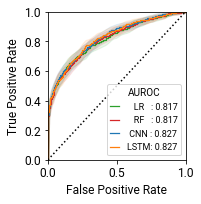

In [7]:
plot_roc_curves(task = 'ARF', T = 4)

LR
Test AUC: 0.757
Test AUC: (0.720, 0.789) percentile 95% CI
RF
Test AUC: 0.760
Test AUC: (0.726, 0.793) percentile 95% CI
CNN_V3
Test AUC: 0.768
Test AUC: (0.733, 0.800) percentile 95% CI
RNN_V2
Test AUC: 0.771
Test AUC: (0.737, 0.802) percentile 95% CI


,LR,RF,CNN_V3,RNN_V2
LR,0,0.718,0.258,0.258
RF,0.718,0,0.522,0.454
CNN_V3,0.258,0.522,0,0.826
RNN_V2,0.258,0.454,0.826,0


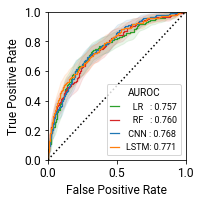

In [34]:
plot_roc_curves(task = 'ARF', T = 12)

LR
Test AUC: 0.825
Test AUC: (0.803, 0.846) percentile 95% CI
RF
Test AUC: 0.809
Test AUC: (0.786, 0.833) percentile 95% CI
CNN_V3
Test AUC: 0.831
Test AUC: (0.811, 0.851) percentile 95% CI
RNN_V2
Test AUC: 0.824
Test AUC: (0.803, 0.845) percentile 95% CI


,LR,RF,CNN_V3,RNN_V2
LR,0,0.02,0.124,0.868
RF,0.02,0,0,0.034
CNN_V3,0.124,0,0,0.076
RNN_V2,0.868,0.034,0.076,0


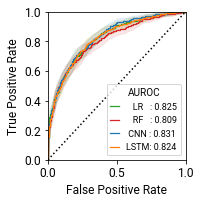

In [8]:
plot_roc_curves(task = 'Shock', T = 4)

LR
Test AUC: 0.792
Test AUC: (0.758, 0.824) percentile 95% CI
RF
Test AUC: 0.773
Test AUC: (0.740, 0.806) percentile 95% CI
CNN_V3
Test AUC: 0.791
Test AUC: (0.758, 0.823) percentile 95% CI
RNN_V2
Test AUC: 0.792
Test AUC: (0.759, 0.823) percentile 95% CI


,LR,RF,CNN_V3,RNN_V2
LR,0,0.022,0.968,0.968
RF,0.022,0,0.078,0.02
CNN_V3,0.968,0.078,0,0.912
RNN_V2,0.968,0.02,0.912,0


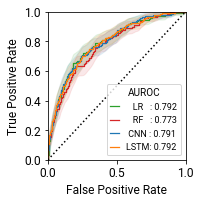

In [9]:
plot_roc_curves(task = 'Shock', T = 12)

LR
Test AUC: 0.856
Test AUC: (0.821, 0.888) percentile 95% CI
RF
Test AUC: 0.814
Test AUC: (0.780, 0.847) percentile 95% CI
CNN_V3
Test AUC: 0.886
Test AUC: (0.854, 0.916) percentile 95% CI
RNN_V2
Test AUC: 0.868
Test AUC: (0.835, 0.897) percentile 95% CI


,LR,RF,CNN_V3,RNN_V2
LR,0,0,0,0.262
RF,0,0,0,0
CNN_V3,0,0,0,0.026
RNN_V2,0.262,0,0.026,0


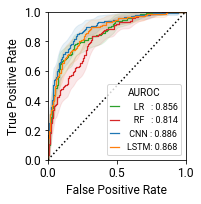

In [10]:
plot_roc_curves(task = 'mortality', T = 48)

## PR curves

In [18]:
def plot_pr_curves(task, T):
    
    def bootstrap_func(i, y_true, y_score):
        yte_true_b, yte_pred_b = utils.resample(y_true, y_score, replace=True, random_state=i)
        return (
            metrics.precision_recall_curve(yte_true_b, yte_pred_b), 
            metrics.auc(*metrics.precision_recall_curve(yte_true_b, yte_pred_b)[1::-1])
        )

    def get_pr_CI(y_true, y_score):
        curves, scores = zip(*Parallel(n_jobs=4)(delayed(bootstrap_func)(i, y_true, y_score) for i in range(1000)))
        print('Test AUPR: {:.3f}'.format(metrics.auc(*metrics.precision_recall_curve(y_true, y_score)[1::-1])))
        print('Test AUPR: ({:.3f}, {:.3f}) percentile 95% CI'.format(np.percentile(scores, 2.5), np.percentile(scores, 97.5)))
#         print('Test AUPR: {:.3f} ({:.3f}, {:.3f}) percentile'.format(np.median(scores), np.percentile(scores, 2.5), np.percentile(scores, 97.5)))
#         print('Test AUPR: {:.3f} ({:.3f}, {:.3f}) empirical'.format(np.mean(scores), np.mean(scores) - 1.96 * np.std(scores), np.mean(scores) + 1.96 * np.std(scores)))
#         print('Test AUPR: {:.3f} ± {:.3f} SE'.format(np.mean(scores), np.std(scores)))
        
        precs = []
        mean_rec = np.linspace(0, 1, 101)
        for prec, rec, _ in curves:
            rec_sorted, prec_sorted = rec[np.argsort(rec)], prec[np.argsort(rec)]
            precs.append(np.interp(mean_rec, rec_sorted, prec_sorted))
        
        mean_prec = np.mean(precs, axis=0)
        std_prec = np.std(precs, axis=0)
        prec_upper = np.minimum(mean_prec + 1.96 * std_prec, 1)
        prec_lower = np.maximum(mean_prec - 1.96 * std_prec, 0)
        return curves, scores, mean_rec, prec_lower, prec_upper

    fig = plt.figure(figsize=(figure_dim, figure_dim))
    aupr_scores = []
    bootstrap_aupr_scores = []
    for model, color in zip(models, colors):
        print(model)
        y_score, y_true = output[task][T][model]
        precision, recall, thresholds_ = metrics.precision_recall_curve(y_true, y_score)
        plt.plot(recall, precision, lw=1.25, label=model, color=color)
        aupr_scores.append(metrics.auc(recall, precision))
        curves, scores, mean_rec, prec_lower, prec_upper = get_pr_CI(y_true, y_score)
        bootstrap_aupr_scores.append(np.array(scores))
        plt.fill_between(mean_rec, prec_lower, prec_upper, alpha=.05, color=color)
    
    # Statistical tests
    df_pval = pd.DataFrame(index=models, columns=models)
    for (i, model_i), (j, model_j) in itertools.product(enumerate(models), enumerate(models)):
        bootstrap_aupr_scores[i], bootstrap_aupr_scores[j]
        pvalue = 2 * min(
            (bootstrap_aupr_scores[i] < bootstrap_aupr_scores[j]).mean(),
            (bootstrap_aupr_scores[i] > bootstrap_aupr_scores[j]).mean(),
        )
        df_pval.iloc[i,j] = pvalue
    display(df_pval)
    
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    lg = plt.legend(
        [
            '   LR   : {:.3f}'.format(aupr_scores[0]), 
            '   RF   : {:.3f}'.format(aupr_scores[1]), 
            ' CNN : {:.3f}'.format(aupr_scores[2]), 
            'LSTM: {:.3f}'.format(aupr_scores[3]), 
        ], 
        title='AUPR',
        loc='best',
#         loc='lower left',
        handlelength=1.0,
        fontsize=9,
    )
    lg.get_title().set_fontsize(10)
#     plt.title('{}.T={}.dt={}'.format(task, T, dt))
    plt.tight_layout()
    plt.savefig('figures/PR.{}.T={}.dt={}.svg'.format(task, T, dt))
    plt.show()

LR
Test AUPR: 0.657
Test AUPR: (0.614, 0.696) percentile 95% CI
RF
Test AUPR: 0.652
Test AUPR: (0.608, 0.690) percentile 95% CI
CNN_V3
Test AUPR: 0.666
Test AUPR: (0.626, 0.705) percentile 95% CI
RNN_V2
Test AUPR: 0.664
Test AUPR: (0.623, 0.703) percentile 95% CI


,LR,RF,CNN_V3,RNN_V2
LR,0,0.538,0.176,0.324
RF,0.538,0,0.116,0.172
CNN_V3,0.176,0.116,0,0.682
RNN_V2,0.324,0.172,0.682,0


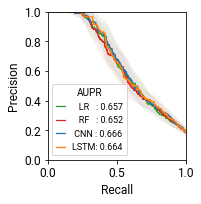

In [12]:
plot_pr_curves('ARF', 4)

LR
Test AUPR: 0.291
Test AUPR: (0.236, 0.354) percentile 95% CI
RF
Test AUPR: 0.317
Test AUPR: (0.255, 0.382) percentile 95% CI
CNN_V3
Test AUPR: 0.294
Test AUPR: (0.238, 0.361) percentile 95% CI
RNN_V2
Test AUPR: 0.326
Test AUPR: (0.267, 0.397) percentile 95% CI


,LR,RF,CNN_V3,RNN_V2
LR,0,0.196,0.792,0.182
RF,0.196,0,0.36,0.7
CNN_V3,0.792,0.36,0,0.154
RNN_V2,0.182,0.7,0.154,0


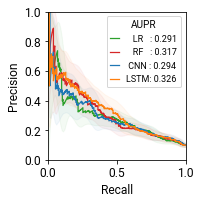

In [37]:
plot_pr_curves('ARF', 12)

LR
Test AUPR: 0.548
Test AUPR: (0.501, 0.595) percentile 95% CI
RF
Test AUPR: 0.516
Test AUPR: (0.467, 0.566) percentile 95% CI
CNN_V3
Test AUPR: 0.541
Test AUPR: (0.493, 0.589) percentile 95% CI
RNN_V2
Test AUPR: 0.541
Test AUPR: (0.497, 0.587) percentile 95% CI


,LR,RF,CNN_V3,RNN_V2
LR,0,0.006,0.44,0.414
RF,0.006,0,0.022,0.05
CNN_V3,0.44,0.022,0,0.996
RNN_V2,0.414,0.05,0.996,0


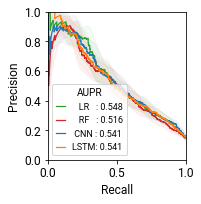

In [17]:
plot_pr_curves('Shock', 4)

LR
Test AUPR: 0.274
Test AUPR: (0.227, 0.338) percentile 95% CI
RF
Test AUPR: 0.288
Test AUPR: (0.231, 0.355) percentile 95% CI
CNN_V3
Test AUPR: 0.295
Test AUPR: (0.239, 0.361) percentile 95% CI
RNN_V2
Test AUPR: 0.314
Test AUPR: (0.251, 0.386) percentile 95% CI


,LR,RF,CNN_V3,RNN_V2
LR,0,0.584,0.272,0.072
RF,0.584,0,0.74,0.152
CNN_V3,0.272,0.74,0,0.186
RNN_V2,0.072,0.152,0.186,0


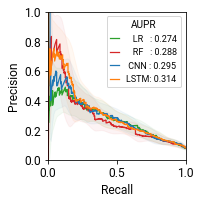

In [14]:
plot_pr_curves('Shock', 12)

LR
Test AUPR: 0.444
Test AUPR: (0.357, 0.545) percentile 95% CI
RF
Test AUPR: 0.357
Test AUPR: (0.279, 0.448) percentile 95% CI
CNN_V3
Test AUPR: 0.531
Test AUPR: (0.434, 0.629) percentile 95% CI
RNN_V2
Test AUPR: 0.510
Test AUPR: (0.411, 0.597) percentile 95% CI


,LR,RF,CNN_V3,RNN_V2
LR,0,0.004,0.006,0.044
RF,0.004,0,0,0
CNN_V3,0.006,0,0,0.448
RNN_V2,0.044,0,0.448,0


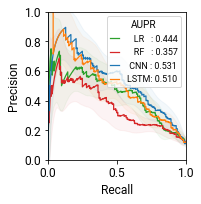

In [19]:
plot_pr_curves('mortality', 48)

## Calibration

In [20]:
def get_calibration_plot(y_true, y_prob, q):
    try:
        out, bins = pd.qcut(y_prob.ravel(), q=q, labels=False, retbins=True)
#         bins = np.percentile(y_prob.ravel(), [0, 20, 40, 60, 80, 100])
        P_true, P_pred = [], []
        for bin_idx in range(q):
            m = (out == bin_idx)
            P_true.append(np.mean(y_true[m]))
            P_pred.append(np.mean(y_prob[m]))
    except:
        print(q)
        print(out)
        raise
    return P_true, P_pred

In [23]:
def plot_calibration_curves(task, T):
    
    def bootstrap_func(i, y_true, y_score, q):
        yte_true_b, yte_pred_b = utils.resample(y_true, y_score, replace=True, random_state=i)
        return get_calibration_plot(yte_true_b, yte_pred_b, q)

    def generate_calibration_CI_and_cloud(y_true, y_score):
#         P_trues, P_preds = zip(*[bootstrap_func(i, y_true, y_score) for i in range(1000)])
        P_trues, P_preds = zip(*Parallel(n_jobs=4)(delayed(bootstrap_func)(i, y_true, y_score, q=5) for i in range(1000)))
        
#         print('Test AUPR: {:.3f} ({:.3f}, {:.3f}) percentile'.format(np.median(scores), np.percentile(scores, 2.5), np.percentile(scores, 97.5)))
#         print('Test AUPR: {:.3f} ({:.3f}, {:.3f}) empirical'.format(np.mean(scores), np.mean(scores) - 1.96 * np.std(scores), np.mean(scores) + 1.96 * np.std(scores)))
#         print('Test AUPR: {:.3f} ± {:.3f} SE'.format(np.mean(scores), np.std(scores)))
        
#         precs = []
#         mean_rec = np.linspace(0, 1, 101)
#         for prec, rec, _ in curves:
#             rec_sorted, prec_sorted = rec[np.argsort(rec)], prec[np.argsort(rec)]
#             precs.append(np.interp(mean_rec, rec_sorted, prec_sorted))
        
#         mean_prec = np.mean(precs, axis=0)
#         std_prec = np.std(precs, axis=0)
#         prec_upper = np.minimum(mean_prec + 1.96 * std_prec, 1)
#         prec_lower = np.maximum(mean_prec - 1.96 * std_prec, 0)
        return P_trues, P_preds
    
    fig = plt.figure(figsize=(figure_dim, figure_dim))
    brier_scores = []
    for model, color in zip(models, colors):
        y_prob, y_true = output[task][T][model] # used predict_proba for LR/RF, and sigmoid layer for CNN/RNN
        P_true, P_pred = get_calibration_plot(y_true, y_prob, q=5)
        brier_score = np.mean(np.square(np.array(P_true) - np.array(P_pred)))
        brier_scores.append(brier_score)
        plt.plot(P_pred, P_true, '.', markersize=5, label=model, color=color, alpha=0.9)
        P_trues, P_preds = generate_calibration_CI_and_cloud(y_true, y_prob)
        yerrs, xerrs = 1.96*np.std(P_trues, axis=0), 1.96*np.std(P_preds, axis=0)
#         plt.plot(P_preds, P_trues, '.', markersize=1, color=color, alpha=0.01, label='_nolegend_')
        markers, caps, bars = plt.errorbar(P_pred, P_true, yerrs, xerrs, '.', markersize=0, elinewidth=1, color=color)
        for bar in bars: bar.set_alpha(0.5)
        for cap in caps: cap.set_alpha(0.5)
    
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('Mean predicted value')
    plt.ylabel('Fraction of positives')
    lg = plt.legend(
        [
            '   LR   : {:.4f}'.format(brier_scores[0]), 
            '   RF   : {:.4f}'.format(brier_scores[1]), 
            ' CNN : {:.4f}'.format(brier_scores[2]), 
            'LSTM: {:.4f}'.format(brier_scores[3]), 
        ], 
        loc='lower right',
        handlelength=0.5,
        bbox_to_anchor=(1.02, -0.02),
        fontsize=9,
        title='Brier score',
    )
    lg.get_title().set_fontsize(10)
    plt.plot([0,1], [0,1], 'k:')
#     plt.title('{}.T={}.dt={}'.format(task, T, dt))
#     plt.xlim(0,0.5)
#     plt.xticks([0,0.1,0.2,0.3,0.4,0.5])
#     plt.ylim(0,0.5)
    plt.xticks([0,0.2,0.4,0.6,0.8,1.0])
    plt.tight_layout()
    plt.savefig('figures/Calibration.{}.T={}.dt={}.svg'.format(task, T, dt))
#     plt.savefig('figures/Calibration.{}.T={}.dt={}.png'.format(task, T, dt), dpi=300)
    plt.show()

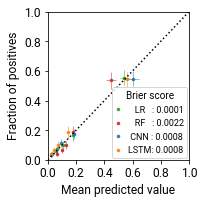

In [24]:
plot_calibration_curves('ARF', 4)

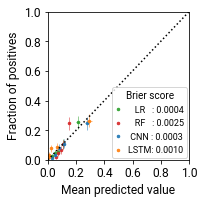

In [25]:
plot_calibration_curves('ARF', 12)

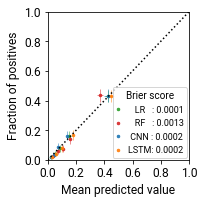

In [26]:
plot_calibration_curves('Shock', 4)

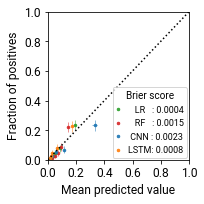

In [27]:
plot_calibration_curves('Shock', 12)

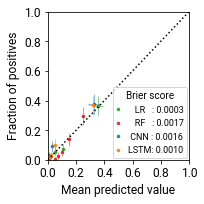

In [28]:
plot_calibration_curves('mortality', 48)